# Group 03: CopyPaste
#### Datasets used: Dataset_Hospital_Vists.csv, test.csv
#### Participants: 

- Gina-Maria Tanja Färber 77211826704
- Muhammad Raza 77211990025
- Ligia Vergara 77212002271


### Contents Draft

1. Problem and Goal Definition
2. Data Understanding
3. Data Quality Check
4. Exploratory Data Analysis
5. Data Cleaning and Basic Preprocessing
6. Train-Test Split
7. Advanced Data Preprocessing
8. Model Building and Fine Tuning
9. Model Evaluation
10. Business Recommendations

### 1. Problem and Goal Definition
#### Problem: Patients in a hospital miss their scheduled appointments.

#### Goal: Develop a machine learning model that predicts if a patient will miss a future appointment.

### 2. Data Understanding
#### 2.1 Dataset Description

- The dataset is at appointment level granularity and contains detail of each appointment and patient.

- It has 14 columns of which 1 will be our target variable: No-show.

- We mostly have information about an appointment's date and place and the patients' health details. A column also shows if a patient received an SMS before the appointment.

#### 2.2 Quick Analysis from Kaggle

- There is missing data in the columns Age, Community, Social Welfare, and some diseases.
- Female to Male ratio is 65:35.
- We have no NULLs in the target variable.
- For Handcap, we have multiple values even though it seems to be a binary variable.

### 3. Data Quality Check

We check our dataset against the following dimensions:

- Uniqueness
- Missing data
- Data type consistency check
- Distribution of Categorical Variables
- Dates inconsistency

In [1]:
# Setting up environment with packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Importing the dataset

df = pd.read_csv("/Users/muhammadraza/Documents/GitHub/BIPM/Data Science/Project/Dataset_Hospital_Visits.csv")
df.head()

# Increase seaborn default resolution

sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')
sns.set_style("ticks")
sns.set(rc={'figure.figsize':(5,6)})

# Give variables to color numbers

green = '#008000'
red = '#ff0000'


In [3]:
## Uniqueness

# Is each row unique?

print("Duplicate rows: " + str(df.duplicated().sum()))

# Is each appointmentID unique?

print("Duplicate appointments: " + str(df['AppointmentID'].duplicated().sum()))

Duplicate rows: 0
Duplicate appointments: 0


We can conclude that the dataset only containts unique IDs and no duplicates.

In [4]:
## Missing Data

# Which columns have missing data?

missing_data = df.isnull().sum()
total_entries = len(df)
percentage_missing = round((missing_data / total_entries) * 100, 2)

missing_info = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage Missing': percentage_missing
})

print(missing_info)

                 Missing Count  Percentage Missing
PatientId                    0                0.00
AppointmentID                0                0.00
Sex                          0                0.00
ScheduledDate                0                0.00
AppointmentDate              0                0.00
Age                       8807                9.96
Community                10713               12.12
SocialWelfare            12519               14.16
Hipertension              8021                9.07
Diabetes                     0                0.00
Alcoholism               14889               16.84
Handcap                      0                0.00
SMS_received                 0                0.00
No-show                      0                0.00


As also seen from Kaggle, Age, Community, SocialWelfare, Hipertension, and Alcoholism have significant null values.

In [5]:
## Data Type Consistency

df.dtypes

PatientId          float64
AppointmentID        int64
Sex                 object
ScheduledDate       object
AppointmentDate     object
Age                float64
Community           object
SocialWelfare       object
Hipertension        object
Diabetes            object
Alcoholism          object
Handcap             object
SMS_received        object
No-show             object
dtype: object

1. ScheduledDate and AppointmentDate must be timestamps and not objects.

In [6]:
# Distribution of Categorical Variables

occ = df.groupby('Handcap').size().reset_index()
print(occ)

  Handcap      0
0       2    139
1       3     11
2       4      3
3      no  86626
4     yes   1642


We assume that this column was meant to be a binary column and the numerical values are bad data. They will be converted to categorical (yes) during preprocessing. The assumption here is that someone entered the number of handicaps to a person rather than a yes or a no.

In [7]:
# Dates inconsistency

from datetime import datetime

df['AppointmentDate'] = df['AppointmentDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').date())
df['ScheduledDate'] = df['ScheduledDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').date())

counts = df['ScheduledDate'] > df['AppointmentDate']
occurrence_counts = counts.value_counts()

print(occurrence_counts)

False    88417
True         4
Name: count, dtype: int64


We see that we have 4 incoherent combination of schedule and appointment dates - they will be taken out in data cleaning stage.

### 4. Exploratory Data Analysis

- Distribution of the target variable.
- Distribution of age. Which age groups account for the most missing appointments?
- Do patients of a certain community miss their appointments more than others?
- Do males or females miss more appointments?

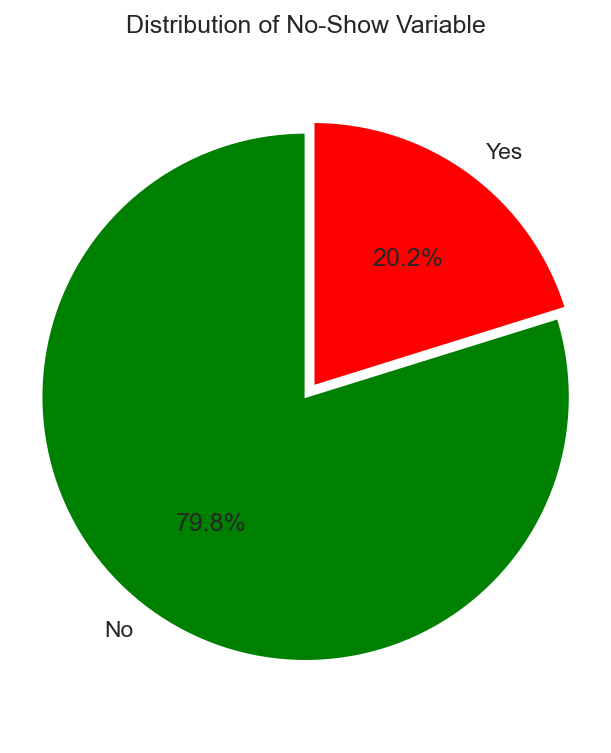

In [8]:
## Distribution of the target variable

value_counts = df['No-show'].value_counts()

labels = value_counts.index
sizes = value_counts.values

colors = [green,red]  # Customize colors
explode = (0.05, 0)  # Explode the 1st slice

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=explode)

plt.title('Distribution of No-Show Variable')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular

plt.show()

1 in 5 appointments are missed on average.

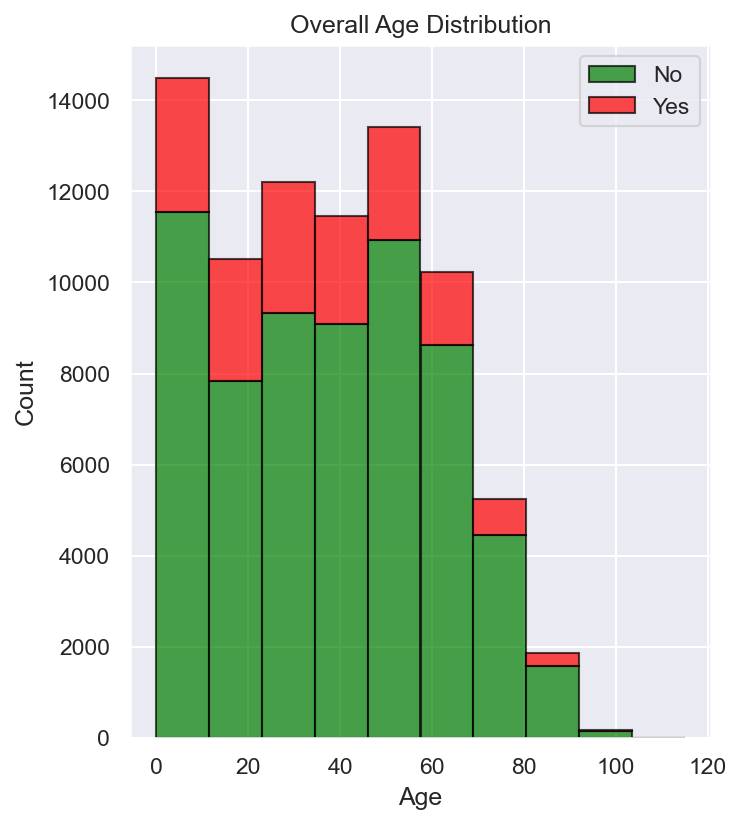

In [9]:
# Which age group misses more appointments?

# Plotting histogram with split bars

plt.hist([df[df['No-show'] == 'No']['Age'], df[df['No-show'] == 'Yes']['Age']],
         bins=10, color=['green', 'red'], alpha=0.7, edgecolor='black', label=['No', 'Yes'], stacked=True)

plt.title('Overall Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()

plt.show()

There is an even distribution of the ratio of appointments missed in the various age groups. This tends to change after age 70 where appointments are missed a lot less.

This could be explained by the fact that older people cannot afford to miss appointments due to more serious health issues and due to the fact that they might have more time on their hand.

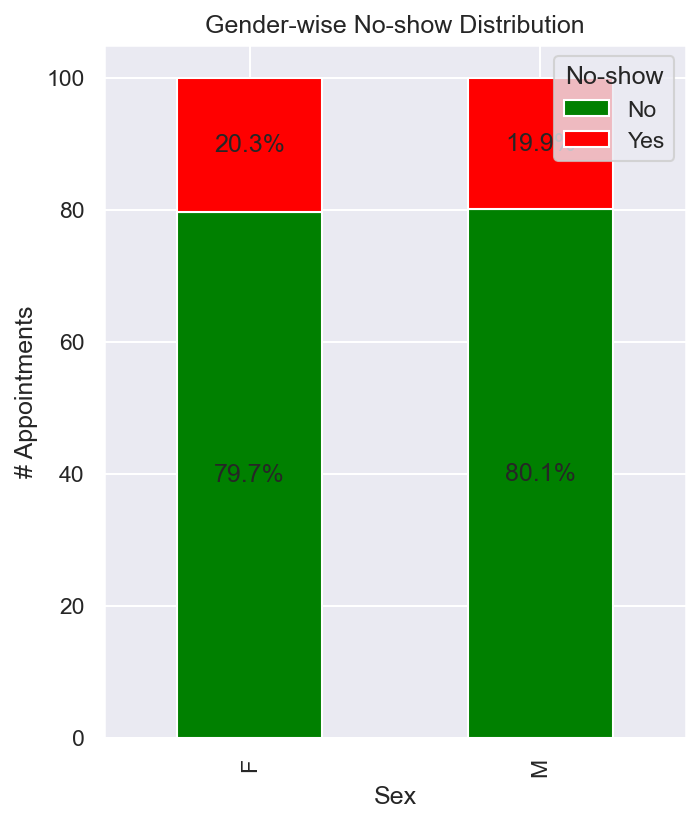

In [10]:
## Which gender misses more appointments?

# Grouping by 'gender' and 'no_show' and count occurrences
grouped_data = df.groupby(['Sex', 'No-show']).size().unstack()

# Calculating percentages

percentages = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

# Plotting a grouped bar chart

ax = percentages.plot(kind='bar', stacked=True, color=[green, red])

# Annotating bars with percentages

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.title('Gender-wise No-show Distribution')
plt.xlabel('Sex')
plt.ylabel('# Appointments')
plt.legend(title='No-show', loc='upper right')

plt.show()

There seems to be 1 in 5 appointments missed for both genders.

/var/folders/1z/kkxxkq_90qldq3ngyx1pj0fr0000gn/T/ipykernel_42276/370316590.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  appointments_per_community_show_up = sorted_df.groupby(['Community', 'No-show']).size().unstack(fill_value=0)


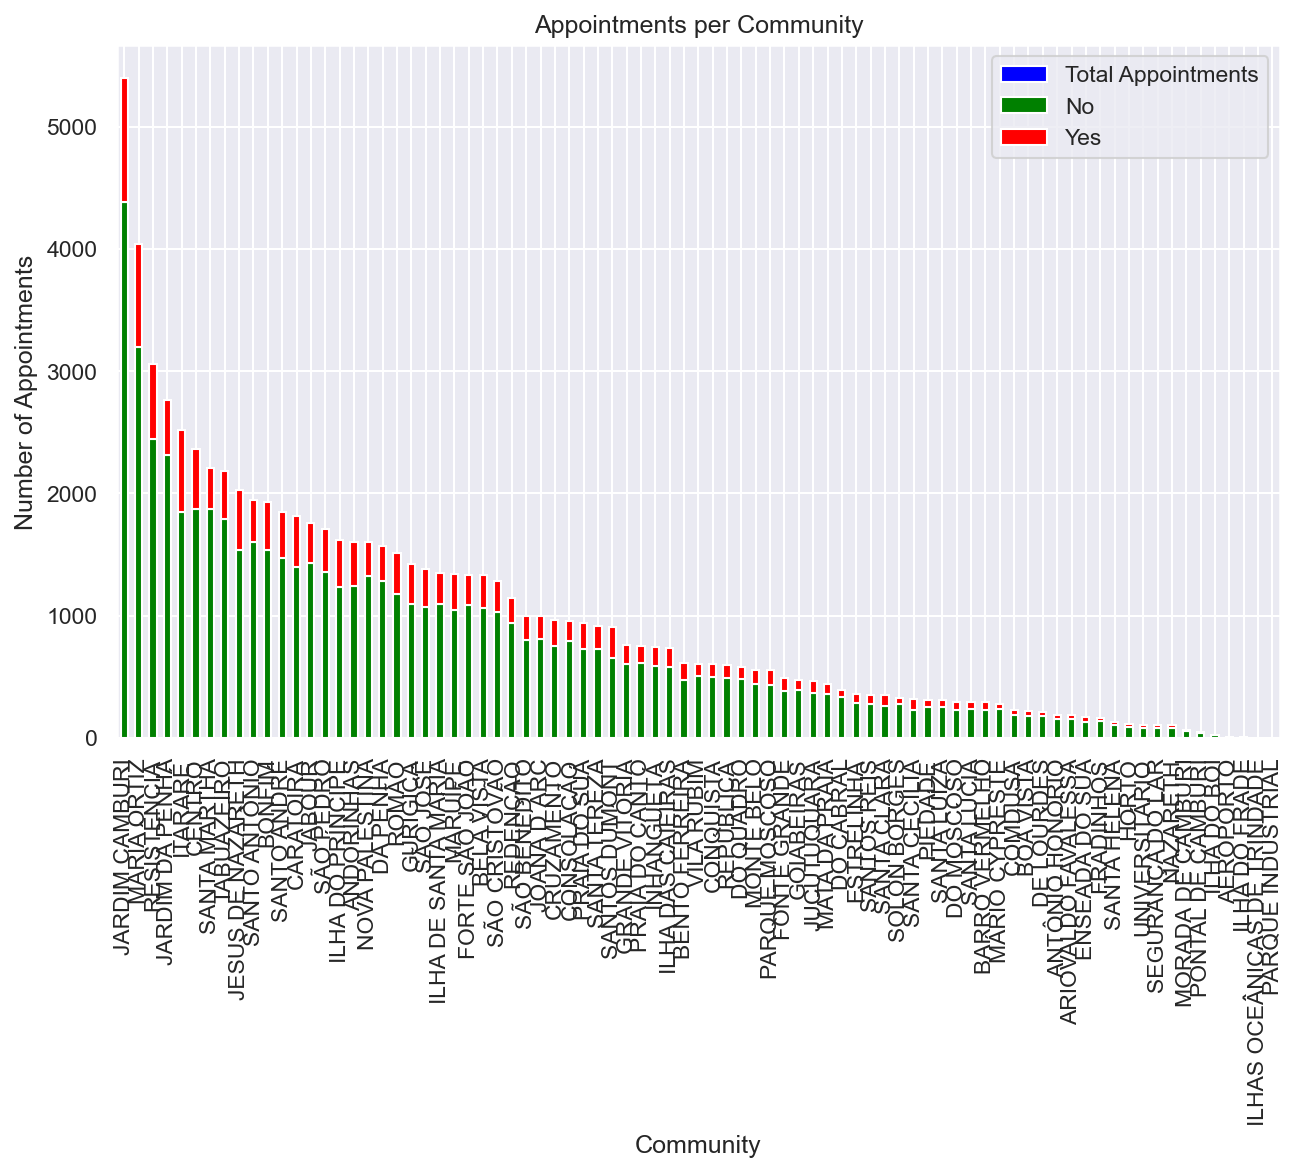

In [11]:

# Do patients of a certain community miss their appointments more than others?

# Counting the total number of appointments per community
total_appointments_per_community = df['Community'].value_counts()

# Sorting the DataFrame based on the total number of appointments

sorted_df = df[df['Community'].isin(total_appointments_per_community.index)].copy()
sorted_df['Community'] = pd.Categorical(sorted_df['Community'], categories=total_appointments_per_community.index, ordered=True)
sorted_df = sorted_df.sort_values(by=['Community'])

# Counting the number of appointments per community split by show_up status

appointments_per_community_show_up = sorted_df.groupby(['Community', 'No-show']).size().unstack(fill_value=0)

# Plotting the bar chart

fig, ax = plt.subplots(figsize=(10, 6))

# Bar chart for total appointments per community

total_appointments_per_community.loc[sorted_df['Community'].unique()].plot(kind='bar', ax=ax, color='blue', label='Total Appointments')

# Bar chart for appointments per community split by show_up status

appointments_per_community_show_up.plot(kind='bar', stacked=True, ax=ax, color=['green', 'red'], label=['Show Up', 'No Show Up'])

# Adding labels and legend

ax.set_title('Appointments per Community')
ax.set_xlabel('Community')
ax.set_ylabel('Number of Appointments')
ax.legend()

plt.show()

No community shows significant difference from the average ratio of missing appointments.

### 5. Data Cleaning and Basic Preprocessing
- Dropping erroneous data
- Substituting illogical entries in Handicap column
- Extrapolating data for each patient where exists
- Time between ScheduledDate and AppointmentDate
- Standardization of Continuous variable

In [12]:
# Keeping original df intact

df_t = df[:]

In [13]:
# Dropping erroneous data: Inconsistent dates from transformed dataframe. We are doing this as we may need to calculate the time difference between the two dates and 
# a negative difference would mean that we could run into processing errors.

df_t = df_t.drop(df[df['ScheduledDate'] > df['AppointmentDate']].index)

In [14]:
# Assuming that the number is the number of handicaps

df_t.loc[df_t['Handcap'].isin(['2','3','4']), 'Handcap'] = 'yes'
occ = df_t.groupby('Handcap').size().reset_index()
print(occ)

  Handcap      0
0      no  86623
1     yes   1794


In [15]:
# Extrapolating missing data: if a patient has non-null attributes for one appointment but not for another, then we can get those missing values if they are filled for another appointment.
# Since our data is within the scope of one year, we do not need to worry about significant changes in ages.

missing_columns = ['Age', 'Community', 'SocialWelfare', 'Hipertension', 'Alcoholism']

for column in missing_columns:
    df_t[column] = df_t.groupby('PatientId')[column].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

/var/folders/1z/kkxxkq_90qldq3ngyx1pj0fr0000gn/T/ipykernel_42276/1343713957.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_t[column] = df_t.groupby('PatientId')[column].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


In [16]:

# Deriving New Feature: Time between ScheduledDate and AppointmentDate. We would like to use this as one of the predictors.

from datetime import timedelta

df_t['time_bw_schedule_appointment'] = df_t['AppointmentDate'] - df_t['ScheduledDate']

## Convert to float (days)

df_t['time_bw_schedule_appointment'] = df_t['time_bw_schedule_appointment'] / pd.Timedelta(days=1)
df_t['time_bw_schedule_appointment'] = df_t['time_bw_schedule_appointment'].astype(float)

In [17]:
# Capitalising yes/no so they can be converted to a binary column.

df_t = df_t.applymap(lambda x: x.capitalize() if isinstance(x, str) else x)
missing_data = df_t.isnull().sum()
total_entries = len(df_t)
percentage_missing = round((missing_data / total_entries) * 100, 2)

/var/folders/1z/kkxxkq_90qldq3ngyx1pj0fr0000gn/T/ipykernel_42276/894698410.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_t = df_t.applymap(lambda x: x.capitalize() if isinstance(x, str) else x)


In [18]:
# Checking for remaining missing data after extrapolation: there is still some. However, we would now have to use more advanced methods of filling it in and would be
# doing it after the train-test split to avoid target leakage.

missing_info = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage Missing': percentage_missing
})

print(missing_info)

                              Missing Count  Percentage Missing
PatientId                                 0                0.00
AppointmentID                             0                0.00
Sex                                       0                0.00
ScheduledDate                             0                0.00
AppointmentDate                           0                0.00
Age                                    3778                4.27
Community                              4631                5.24
SocialWelfare                          5450                6.16
Hipertension                           3406                3.85
Diabetes                                  0                0.00
Alcoholism                             6611                7.48
Handcap                                   0                0.00
SMS_received                              0                0.00
No-show                                   0                0.00
time_bw_schedule_appointment            

### 6. Train-Test Split

In [19]:
from sklearn.model_selection import train_test_split

# Avoiding Target Leakage by ensuring each patient is only in one dataset.

unique_patient_ids = df_t['PatientId'].unique()

# Splitting into test and train set.

patients_train, patients_test = train_test_split(unique_patient_ids, test_size=0.3, random_state=42)

# Removing the unnecessary columns as they are not needed anymore: both date columns as we have the difference now.
# We do not need Patient and Appointment IDs (trivial).
# No-show is the target variable which has to be removed from training.
# Scheduled and Appointment Dates are not needed as we have the difference between them.

columns_to_drop = ["PatientId", "No-show", "AppointmentID", "ScheduledDate", "AppointmentDate"]

# Splitting into train and test

X_train = df_t[df_t['PatientId'].isin(patients_train)].drop(columns_to_drop, axis=1)
y_train = df_t[df_t['PatientId'].isin(patients_train)]["No-show"]

X_test = df_t[df_t['PatientId'].isin(patients_test)].drop(columns_to_drop, axis=1)
y_test = df_t[df_t['PatientId'].isin(patients_test)]["No-show"]

In [20]:
## Checking Target variable ratio in both groups to handle potential class imbalance

train_counts = y_train.value_counts(normalize=True) * 100
train_counts

No-show
No     79.827094
Yes    20.172906
Name: proportion, dtype: float64

In [21]:
## Checking Target variable in both groups

test_counts = y_test.value_counts(normalize=True) * 100
test_counts

No-show
No     79.77209
Yes    20.22791
Name: proportion, dtype: float64

In [22]:
# Getting an overview of how X_train looks like

X_train.head()

,Sex,Age,Community,SocialWelfare,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,time_bw_schedule_appointment
0,F,24.0,Resistência,No,No,No,No,No,No,79.0
2,F,19.0,Jardim da penha,No,No,No,No,No,No,0.0
3,F,55.0,Jesus de nazareth,No,Yes,No,No,No,No,0.0
5,F,51.0,Maruípe,No,Yes,No,No,No,Yes,13.0
8,F,NaN,Santos dumont,NaN,No,No,No,No,No,1.0


### 7. Advanced Data Preprocessing
- Handling remaining missing Data: Imputation
- OneHotEncoding for Categorical Vairables
- Feature Selection based on Correlation Matrix
- Feature Selection based on Information Gain
- Feature Selection based on Automated Methods i.e. SelectKBest()

In [23]:
# Dealing with missing values via imputation
# We went with median as it is a more robust to outliers choice and we did detect some outliers in an adhoc query.

from sklearn.impute import SimpleImputer

median_imp = SimpleImputer(strategy='median', add_indicator=False)
mode_imp = SimpleImputer(strategy='most_frequent', add_indicator=False)

In [24]:
# One Hot Encoding of Categorical Variables
# For the purpose of the ML algorithms we are planning to use, we needed to one hot encode some binary features + the community one (which has a high cardinality).

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False, drop='if_binary')

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Separating columns into numeric and categorical
# These will also be the columns that are the results of feature permutation in section 9.

numeric_features = ["Age", "time_bw_schedule_appointment"]
categorical_features = ['SocialWelfare', 'Sex', 'Alcoholism', 'Hipertension', "Community"]

# Creating transformers and encapsulating them in pipelines.
# 1. For handling the numerical features with only the imputer 
# 2. For handling the categorical variables with imputer and the one hot encoding.

numeric_transformer = Pipeline(steps=[
    ('imputer', median_imp)
])

categorical_transformer = Pipeline(steps=[
    
    ('imputer', mode_imp),
    ('onehot', ohe)
])

# Applying transformers using ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

# Applying the column transformer to the X_train to get rid of missing values and have encoding

transformed_train = preprocessor.fit_transform(X_train)

In [26]:
# Confirming we have no remaining missing values in X_train

columns_train = preprocessor.get_feature_names_out()
transformed_train = pd.DataFrame(transformed_train, columns=columns_train)
transformed_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61652 entries, 0 to 61651
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   numeric__Age                                        61652 non-null  float64
 1   numeric__time_bw_schedule_appointment               61652 non-null  float64
 2   categorical__SocialWelfare_Yes                      61652 non-null  float64
 3   categorical__Sex_M                                  61652 non-null  float64
 4   categorical__Alcoholism_Yes                         61652 non-null  float64
 5   categorical__Hipertension_Yes                       61652 non-null  float64
 6   categorical__Community_Aeroporto                    61652 non-null  float64
 7   categorical__Community_Andorinhas                   61652 non-null  float64
 8   categorical__Community_Antônio honório              61652 non-null  float64


In [27]:
# Confirming we have no remaining missing values in X_test

transformed_test = preprocessor.fit_transform(X_test)

# Seeing the feature names in order to 'see beneath the hood'

columns_test = preprocessor.get_feature_names_out()
transformed_test = pd.DataFrame(transformed_test, columns= columns_test)
transformed_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26765 entries, 0 to 26764
Data columns (total 84 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   numeric__Age                                26765 non-null  float64
 1   numeric__time_bw_schedule_appointment       26765 non-null  float64
 2   categorical__SocialWelfare_Yes              26765 non-null  float64
 3   categorical__Sex_M                          26765 non-null  float64
 4   categorical__Alcoholism_Yes                 26765 non-null  float64
 5   categorical__Hipertension_Yes               26765 non-null  float64
 6   categorical__Community_Aeroporto            26765 non-null  float64
 7   categorical__Community_Andorinhas           26765 non-null  float64
 8   categorical__Community_Antônio honório      26765 non-null  float64
 9   categorical__Community_Ariovaldo favalessa  26765 non-null  float64
 10  categorica

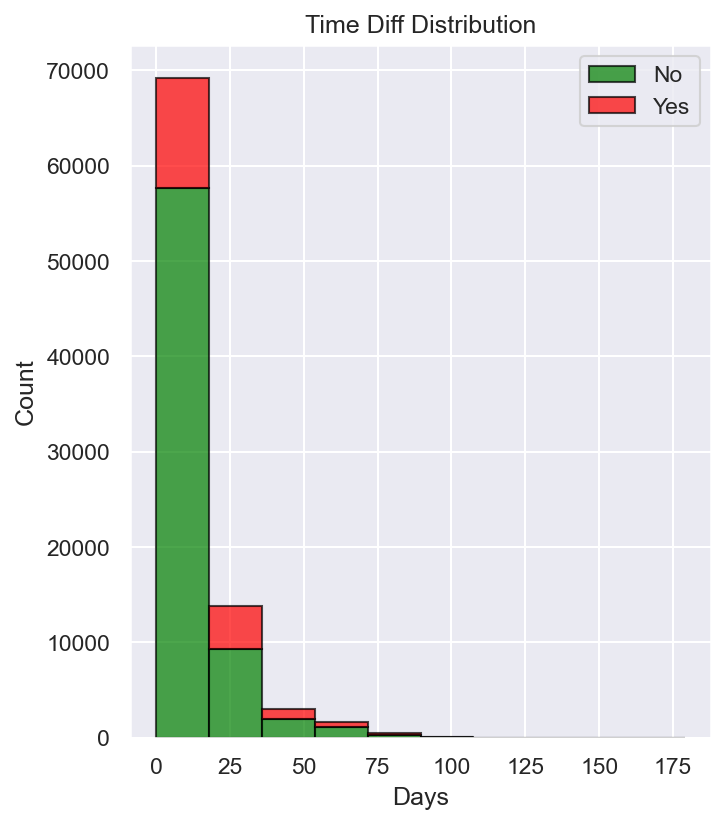

In [28]:
# EDA: Plotting histogram of split of time duration between scheduled and appointment date to check if there is any correlation between time and missed appointments.
# From a first glance it does not seem that obvious.

plt.hist([df_t[df_t['No-show'] == 'No']['time_bw_schedule_appointment'], df_t[df_t['No-show'] == 'Yes']['time_bw_schedule_appointment']],
         bins=10, color=['green', 'red'], alpha=0.7, edgecolor='black', label=['No', 'Yes'], stacked=True)

plt.title('Time Diff Distribution')
plt.xlabel('Days')
plt.ylabel('Count')
plt.legend()

plt.show()


### 7.2 Feature Selection

We would like to understand which features are meaningul in terms of information gain and predictive power while which ones simply add to the noise.

- Feature Selection based on Information Gain
- Feature Selection based on Automated Methods i.e. SelectKBest()

In [29]:
## Concatenating X_train and y_train for feature selection

transformed_train = transformed_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

df_feature_selection = pd.concat([transformed_train, y_train], axis = 1)

In [30]:
# Encoding the no-show column to int to be able to use in feature selection algorithm

df_t_encoded = pd.get_dummies(df_feature_selection, columns=['No-show'], drop_first=True).astype(int)

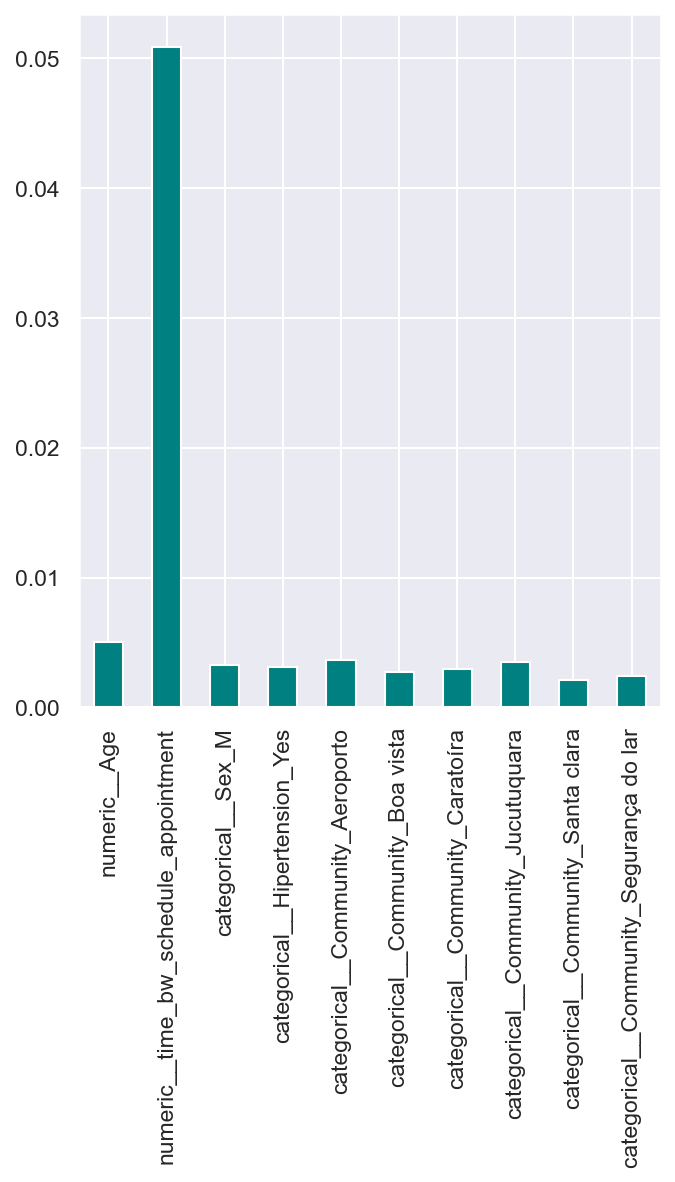

In [31]:
# Feature Selection based on Info Gain

from sklearn.feature_selection import mutual_info_classif

X = df_t_encoded.drop("No-show_Yes", axis=1)
y = df_t_encoded['No-show_Yes']

importances = mutual_info_classif(X, y)
feature_importances = pd.Series(importances, df_t_encoded.columns[0:len(df_t_encoded.columns)-1])

# Filtering for the relatively more important ones after seeing a messy chart in the first go.

filtered_importances = feature_importances[feature_importances > 0.002]

filtered_importances.plot(kind="bar", color="teal")
plt.show()

In [32]:
# Trying out an alternative feature selection method: KBest.

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression, f_classif
from numpy import array

# Creating training set and prediction target

X = df_t_encoded.drop("No-show_Yes", axis=1)
y = df_t_encoded['No-show_Yes']

# Performing feature selection
# We arbitrarily chose 4 as the number of features.

select = SelectKBest(score_func=f_classif, k=4)
select.fit_transform(X,y)

filter = select.get_support() 
features = array(X.columns)
 
print(features[filter])

['numeric__Age' 'numeric__time_bw_schedule_appointment'
 'categorical__SocialWelfare_Yes' 'categorical__Hipertension_Yes']


The two methods presented age and time bw schedule appointment as the most important ones while there were conflicts in some categorical ones.
Later we try a manual approach to find the combination of features which reaches a good level of generalization.

### 8. Model Building


#### 8.1 Decision Tree

We started with a simple decision tree as a common classification algorithm to see how a 'weak' classifier would work on the dataset.
Turned out using this in the soft voting classifier brings the score down so we took it out of the soft voting classifier.

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

clf = DecisionTreeClassifier()

# Creating pipeline for decision tree using the preprocessor from advanced pre-processing and the classifier instantiated.

pipe_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', clf)]
)

In [34]:
# Pipeline shape

pipe_dt

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age',
                                                   'time_bw_schedule_appointment']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  ['SocialWelfare', 'Sex',
                                                   'Alcoholism', 'Hipertension',
                                                   'Community'])])),
                ('classifier', DecisionTreeClassifier())])

In [35]:
# Training the model

pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age',
                                                   'time_bw_schedule_appointment']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  ['SocialWelfare', 'Sex',
                                                   'Alcoholism', 'Hipertension',
                                                   'Community'])])),
                ('classifier', DecisionTreeClassifier())])

In [36]:
# Making the predictions

y_pred = pipe_dt.predict(X_test)

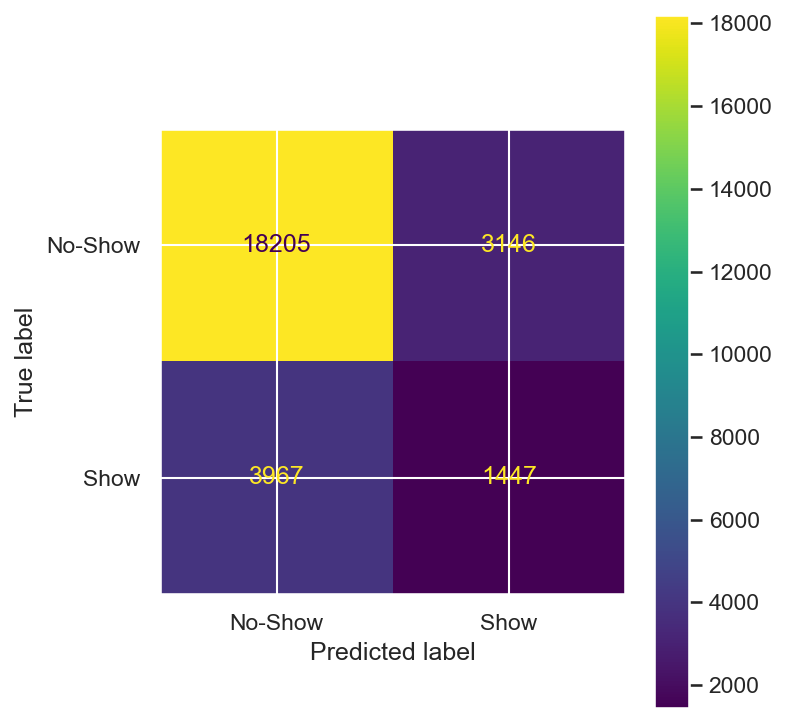

In [37]:
# Evaluating the model

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

display_labels=['No-Show', 'Show']
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=display_labels)
disp.plot()
plt.show()

In [38]:
# Print a classification report

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.82      0.85      0.84     21351
         Yes       0.32      0.27      0.29      5414

    accuracy                           0.73     26765
   macro avg       0.57      0.56      0.56     26765
weighted avg       0.72      0.73      0.73     26765



We see room for improvement considering the low f1 score for 'Yes' so build other models: XGBoost, Logistic Regression, and Random Forrest.

#### 8.2 Random Forest

- Due to decision tree having a lower score, we decide to make a random forest as this is just many decision trees combined together, therefore increasing the predictive power.

In [39]:

from sklearn.ensemble import RandomForestClassifier

# Instantiating Random Forest

rf = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features='log2', max_depth=None, random_state=42, n_jobs=-1)

pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rf)]
)

# Training the model

pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age',
                                                   'time_bw_schedule_appointment']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  ['SocialWelfare', 'Sex',
                                                   'Alcoholism', 'Hipertension',
                                                   'Community'])])),
                ('classifier',
                 RandomForestClassifier(max_features='log2', n_jobs=-1,
                                        random_state=42))])

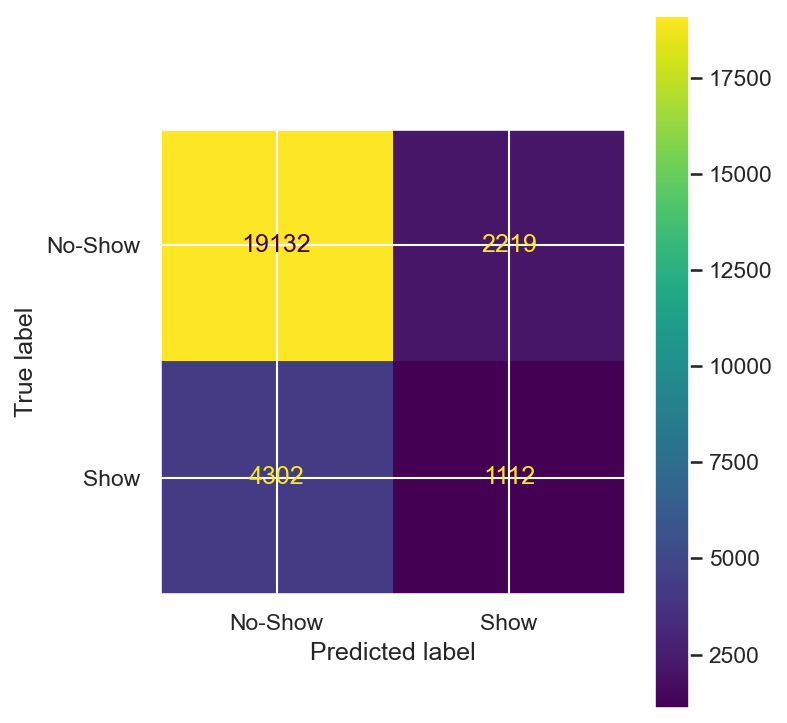

              precision    recall  f1-score   support

          No       0.82      0.90      0.85     21351
         Yes       0.33      0.21      0.25      5414

    accuracy                           0.76     26765
   macro avg       0.58      0.55      0.55     26765
weighted avg       0.72      0.76      0.73     26765



In [40]:
# Making predicitions

preds_rf = pipe_rf.predict(X_test)
preds_rf
display_labels=['No-Show', 'Show']
cm = confusion_matrix(y_test, preds_rf, labels=pipe_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=display_labels)
disp.plot()
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_test, preds_rf))

We see that the accuracy and other metrics have increased, which is a sign we are heading in the right direction. However, we also must consider which hyper parameters would increase the model performance.

In [41]:
# Ensuring y train and y test are encoded binary

mapping = {'No': 0, 'Yes': 1}
y_train = y_train.replace(mapping)
y_test = y_test.replace(mapping)

In [42]:
# We are removing these columns as they were not found to be present within both test and train splits. Therefore, we are deleting them for simplicity.
# There could potentially be more robust ways of doing this; however, considering the trade-off of simplicity.time and robusntess, we are using a workaround.

transformed_train = transformed_train.drop(columns=['categorical__Community_Ilhas oceânicas de trindade', "categorical__Community_Parque industrial","categorical__Community_Ilha do frade" ])

##### 8.2.1 Random Search

- Random Search allows us to specify a set of parameters for the algorithm to sift through and choose the best combination.
- It helps us more than GridSearch as we expect lower marginal value from GridSearch compared to the computation time.
- We focused on not having an overfitted model by optimizing for max_depth, min_samples_split, and min_samples_left.
- On the other hand we also did not want an underfitted model which cannot pick up trends sufficiently so we used n_estimators.

In [43]:
# Optimizing HyperParameters

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Creating a RandomizedSearchCV object

random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=20, scoring='f1', cv=5, random_state=42)

# Fitting the RandomizedSearchCV object on training

random_search.fit(transformed_train, y_train)

# Retrieving the best model and hyperparameters

best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Evaluating the best model on the test set

y_pred = best_model.predict(transformed_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print(f"Best Model Accuracy on Test Set: {accuracy:.4f}")
print(f"Best Model F1 on Test Set: {f1:.4f}")
print(f"Best Model Recall on Test Set: {recall:.4f}")

Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best Model Accuracy on Test Set: 0.7585
Best Model F1 on Test Set: 0.2553
Best Model Recall on Test Set: 0.2047


##### 8.2.2. Halving Grid Search

- We wanted to compare the hyperparameter tuning approach to some other approach.
- Used Halving Grid Search as it is less computationally expensive as Grid Search but also does work on promising hyperparameter configurations.

In [45]:

# enable_halving_search_cv us implicitly needed but not explicitly called
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# Defining the hyperparameter grid

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']

}

# Creating a HalvingGridSearchCV object (Hyperband with grid search)

hyperband_search = HalvingGridSearchCV(rf, param_grid, factor=3, cv=3, random_state=42, scoring="f1")

# Fitting the Hyperband search on the training data

hyperband_search.fit(transformed_train, y_train)

best_rf_model = hyperband_search.best_estimator_
best_params = hyperband_search.best_params_

y_pred = best_rf_model.predict(transformed_test)

f1 = f1_score(y_test, y_pred)
print(f"Best Model F1 on Test Set: {f1:.4f}")
print("Best Hyperparameters:", best_params)

Best Model F1 on Test Set: 0.2594
Best Hyperparameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


#### 8.3 XGBoost

- To further test out if we could improve the prediction accuracy, we tried more model models.
- We used XGBoost as this is widely considered one of the best performing classifiers.
- Although the algorithm does also create decision trees, the key difference is the use of a boosting method and not a simple bagging one - they pick up on errors of each tree.

In [46]:
from xgboost import XGBClassifier

# Giving more weight to the minority class
# XGBoost is sensitive to imbalanced classes

num_positive_instances = np.sum(y_train == 1)
num_negative_instances = np.sum(y_train == 0)

imbalance_ratio = num_negative_instances / num_positive_instances

# Using a binary classifier objective, inputting the imbalance ratio we calculated, and going for some parameters based on the searches
# We use binary:logistic as objective as we would like the probabilities of prediction and not a hard voting 0 or 1. This would later help us in the soft voting classifier.

xgb = XGBClassifier(objective='binary:logistic', scale_pos_weight = imbalance_ratio, subsample = 1.0 , n_estimators = 200, max_depth = 10, learning_rate = 0.1, gamma = 1, colsample_bytree = 0.8 )

pipe_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb)]
)

pipe_xgb.fit(X_train, y_train)
preds_xgb = pipe_xgb.predict(X_test)

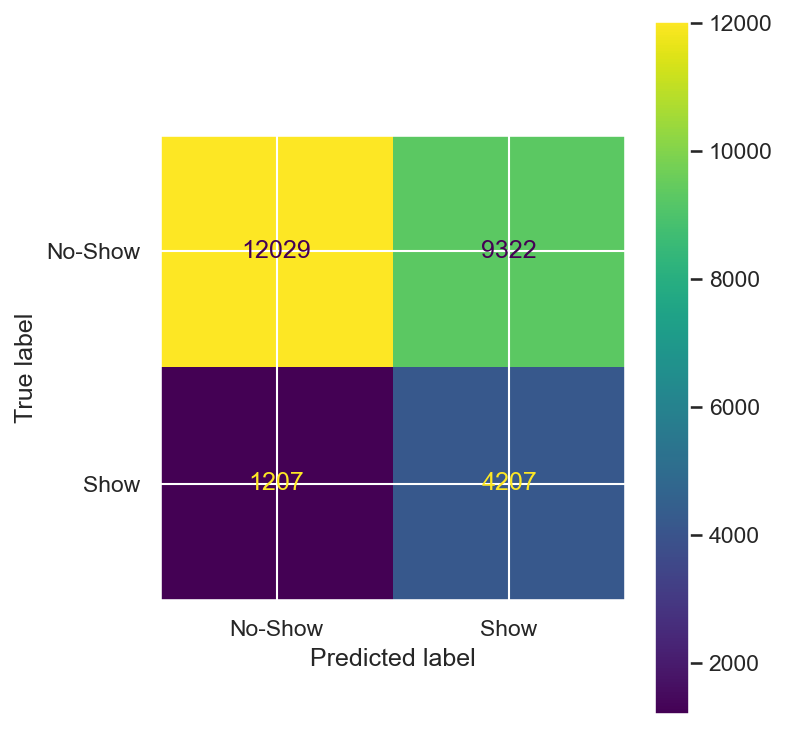

In [48]:
display_labels=['No-Show', 'Show']
cm = confusion_matrix(y_test, preds_xgb, labels=pipe_xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=display_labels)
disp.plot()
plt.show()

In [49]:
# Classification Report

from sklearn.metrics import classification_report
print(classification_report(y_test, preds_xgb))

              precision    recall  f1-score   support

           0       0.91      0.56      0.70     21351
           1       0.31      0.78      0.44      5414

    accuracy                           0.61     26765
   macro avg       0.61      0.67      0.57     26765
weighted avg       0.79      0.61      0.64     26765



##### 8.3.1 Random Search

Parameters:

- n_estimators, max_depth, learning_rate: to ensure a balance between under and over fitting
- gamme: the regularization parameter (since XGBoost supports built-in parameterization)
- scale_pos_weight: playing around with different weights of the class imbalances

In [50]:
# Optimizing HyperParameters

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'scale_pos_weight': [2, 4, 6, 8]
}

# Creating a RandomizedSearchCV object

random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=10, scoring='f1', cv=5, random_state=42)

# Fitting the RandomizedSearchCV object on training set

random_search.fit(transformed_train, y_train)

# Retrieving the best model and hyperparameters

best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Evaluating the best model on the test set

y_pred = best_model.predict(transformed_test)
y_pred

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print(f"Best Model Accuracy on Test Set: {accuracy:.4f}")
print(f"Best Model F1 on Test Set: {f1:.4f}")
print(f"Best Model Recall on Test Set: {recall:.4f}")

Best Hyperparameters: {'subsample': 0.9, 'scale_pos_weight': 4, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}
Best Model Accuracy on Test Set: 0.5889
Best Model F1 on Test Set: 0.4462
Best Model Recall on Test Set: 0.8188


##### 8.3.2. Halving Random Search

- Following a similar approach as Random Forest, we run Halving Random Search to see if we can find better a performing combination of hyperparameters.
- Halving Grid Search was too computationally expensive so a Halving Random Search was preferred.

In [51]:
from sklearn.model_selection import HalvingRandomSearchCV

# Defining the hyperparameter grid

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'scale_pos_weight': [2, 4, 6, 8]

}

# Createing a HalvingGridSearchCV object (Hyperband with grid search)

hyperband_search = HalvingRandomSearchCV(xgb, param_grid, factor=3, cv=3, random_state=42, scoring="f1",max_resources=20)

# Fitting the Hyperband search on the training data

hyperband_search.fit(transformed_train, y_train)


best_rf_model = hyperband_search.best_estimator_
best_params = hyperband_search.best_params_

y_pred = best_rf_model.predict(transformed_test)

f1 = f1_score(y_test, y_pred)
print(f"Best Model F1 on Test Set: {f1:.4f}")
print("Best Hyperparameters:", best_params)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Best Model F1 on Test Set: 0.4362
Best Hyperparameters: {'subsample': 1.0, 'scale_pos_weight': 6, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.8}


#### 8.4 Logistic Regression

- We wanted to add variety to our approaches. So far we only had tree based models.
- Also, its a model that focuses on class probabilities and therefore would also help us in the soft voting classifier.

In [52]:
from sklearn.linear_model import LogisticRegression

# Instantiating Logistic Regression

# Parameter choice: 
# Penalty term adds a control to over fitting. We use L2 as it is more stable than L1 and does not reduce feature to 0. 

lgr = LogisticRegression(class_weight = 'balanced', solver = 'liblinear', penalty = 'l2', fit_intercept = True, C = 0.001, dual=True)

pipe_lgr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lgr)]
)

pipe_lgr.fit(X_train, y_train)

preds_lgr = pipe_lgr.predict(X_test)
preds_lgr

array([1, 1, 1, ..., 1, 0, 0])

##### 8.4.1 Random Search

In [53]:
# Optimizing HyperParameters

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

param_dist = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 4}] 
}
# Creating a RandomizedSearchCV object

random_search = RandomizedSearchCV(lgr, param_distributions=param_dist, n_iter=30, scoring='f1', cv=5, random_state=42)

# Fitting the RandomizedSearchCV object on train

random_search.fit(transformed_train, y_train)

# Retrieving the best model and hyperparameters

best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Evaluating the best model on the test set

y_pred = best_model.predict(transformed_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print(f"Best Model Accuracy on Test Set: {accuracy:.4f}")
print(f"Best Model F1 on Test Set: {f1:.4f}")
print(f"Best Model Recall on Test Set: {recall:.4f}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increas

Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l2', 'fit_intercept': False, 'class_weight': {0: 1, 1: 4}, 'C': 0.001}
Best Model Accuracy on Test Set: 0.6655
Best Model F1 on Test Set: 0.4086
Best Model Recall on Test Set: 0.5713


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


##### 8.4.2 Halving Grid Search

We comment this part out since halving search did not provide better results than random search. Hence, there is no need to spend computational resources here.

In [ ]:
# from sklearn.experimental import enable_halving_search_cv
# from sklearn.model_selection import HalvingGridSearchCV
# from sklearn.datasets import make_classification


# # Define the hyperparameter grid

# param_grid = {
#     'penalty': ['l1', 'l2'],
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'fit_intercept': [True, False],
#     'solver': ['liblinear', 'saga'] 

# }

# # Create a HalvingGridSearchCV object (Hyperband with grid search)
# hyperband_search = HalvingGridSearchCV(lgr1, param_grid, factor=3, cv=3, random_state=42, scoring="f1",max_resources=20)

# # Fit the Hyperband search on the training data

# hyperband_search.fit(transformed_train, y_train)

# best_rf_model = hyperband_search.best_estimator_
# best_params = hyperband_search.best_params_

# y_pred = best_rf_model.predict(transformed_test)

# f1 = f1_score(y_test, y_pred)
# print(f"Best Model F1 on Test Set: {f1:.4f}")
# print("Best Hyperparameters:", best_params)

#### 8.5 Voting Classifier

- Ensemble combines the power of all, so this was tried out and did prove to have the best results.
- We took the decision tree out since for voting classifier as it is not recommended to include algorithms with similar approaches. Therefore, we took the decision tree out.

In [54]:
from sklearn.ensemble import VotingClassifier

# We observed after some hit and trial that these weights were providing a high score.

weights = [2, 2, 1]

## Compare both the soft and hard voting classifier.

svc = VotingClassifier(estimators=[('xgb', xgb), ('lgr', lgr), ('rf', rf)], voting='soft', weights=weights)
hvc = VotingClassifier(estimators=[('dt', clf), ('xgb', xgb), ('rf', rf)], voting='hard')

pipe_svc = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', svc)]
)

pipe_hvc = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', hvc)]
)

In [55]:
pipe_svc.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age',
                                                   'time_bw_schedule_appointment']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  ['SocialWelfare', 'Sex',
                                                   '...
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=200,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...)),
                                              ('lgr',
                                               LogisticRegression(C=0.001,
                                                                  class_weight='balanced',
                                                                  dual=True,
                                                                  solver='liblinear')),
                                              ('rf',
                                               RandomForestClassifier(max_features='log2',
                                                                      n_jobs=-1,
                                                                      random_state=42))],
                                  voting='soft', weights=[2, 2, 1]))])

In [56]:
pipe_hvc.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age',
                                                   'time_bw_schedule_appointment']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  ['SocialWelfare', 'Sex',
                                                   '...
                                                             learning_rate=0.1,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=10,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=200,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...)),
                                              ('rf',
                                               RandomForestClassifier(max_features='log2',
                                                                      n_jobs=-1,
                                                                      random_state=42))]))])

In [57]:
# # Evaluate the classifiers

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

hard_voting_pred = pipe_hvc.predict(X_test)
soft_voting_pred = pipe_svc.predict(X_test)

print("F1 with Hard Voting:", f1_score(y_test, hard_voting_pred))
print("F1 with Soft Voting:", f1_score(y_test, soft_voting_pred))
print("Accuracy with Hard Voting:", precision_score(y_test, hard_voting_pred))
print("Accuracy with Soft Voting:", precision_score(y_test, soft_voting_pred))
print("Accuracy with Hard Voting:", recall_score(y_test, hard_voting_pred))
print("Accuracy with Soft Voting:", recall_score(y_test, soft_voting_pred))

F1 with Hard Voting: 0.32384913507893
F1 with Soft Voting: 0.4210830324909747
Accuracy with Hard Voting: 0.33165537270087125
Accuracy with Soft Voting: 0.3456614509246088
Accuracy with Hard Voting: 0.31640192094569636
Accuracy with Soft Voting: 0.5386036202438124


Soft Voting beats Hard Voting Classifier, so we use that for making the final predictions on the test set.

### 9. Model Evaluation

#### 9.1 Feature Permutation

We are attempting a more advanced way of understanding how different features contribute to the predictions.

In [58]:
from sklearn.metrics import accuracy_score

# Using accuracy as a simple to understand measure

y_pred_original = pipe_svc.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred_original)
print(f"Accuracy on original data: {accuracy_original:.4f}")

Accuracy on original data: 0.7004


In [59]:
from sklearn.inspection import permutation_importance

# Permutation importance will shuffle the values of the chosen columns and see which ones are actually contributing to the predictive power. If the shuffling leads to a significant
# decrease in the accuracy of the model, then the feature held importance.

perm_result = permutation_importance(pipe_svc, X_test, y_test, n_repeats=30, random_state=42)

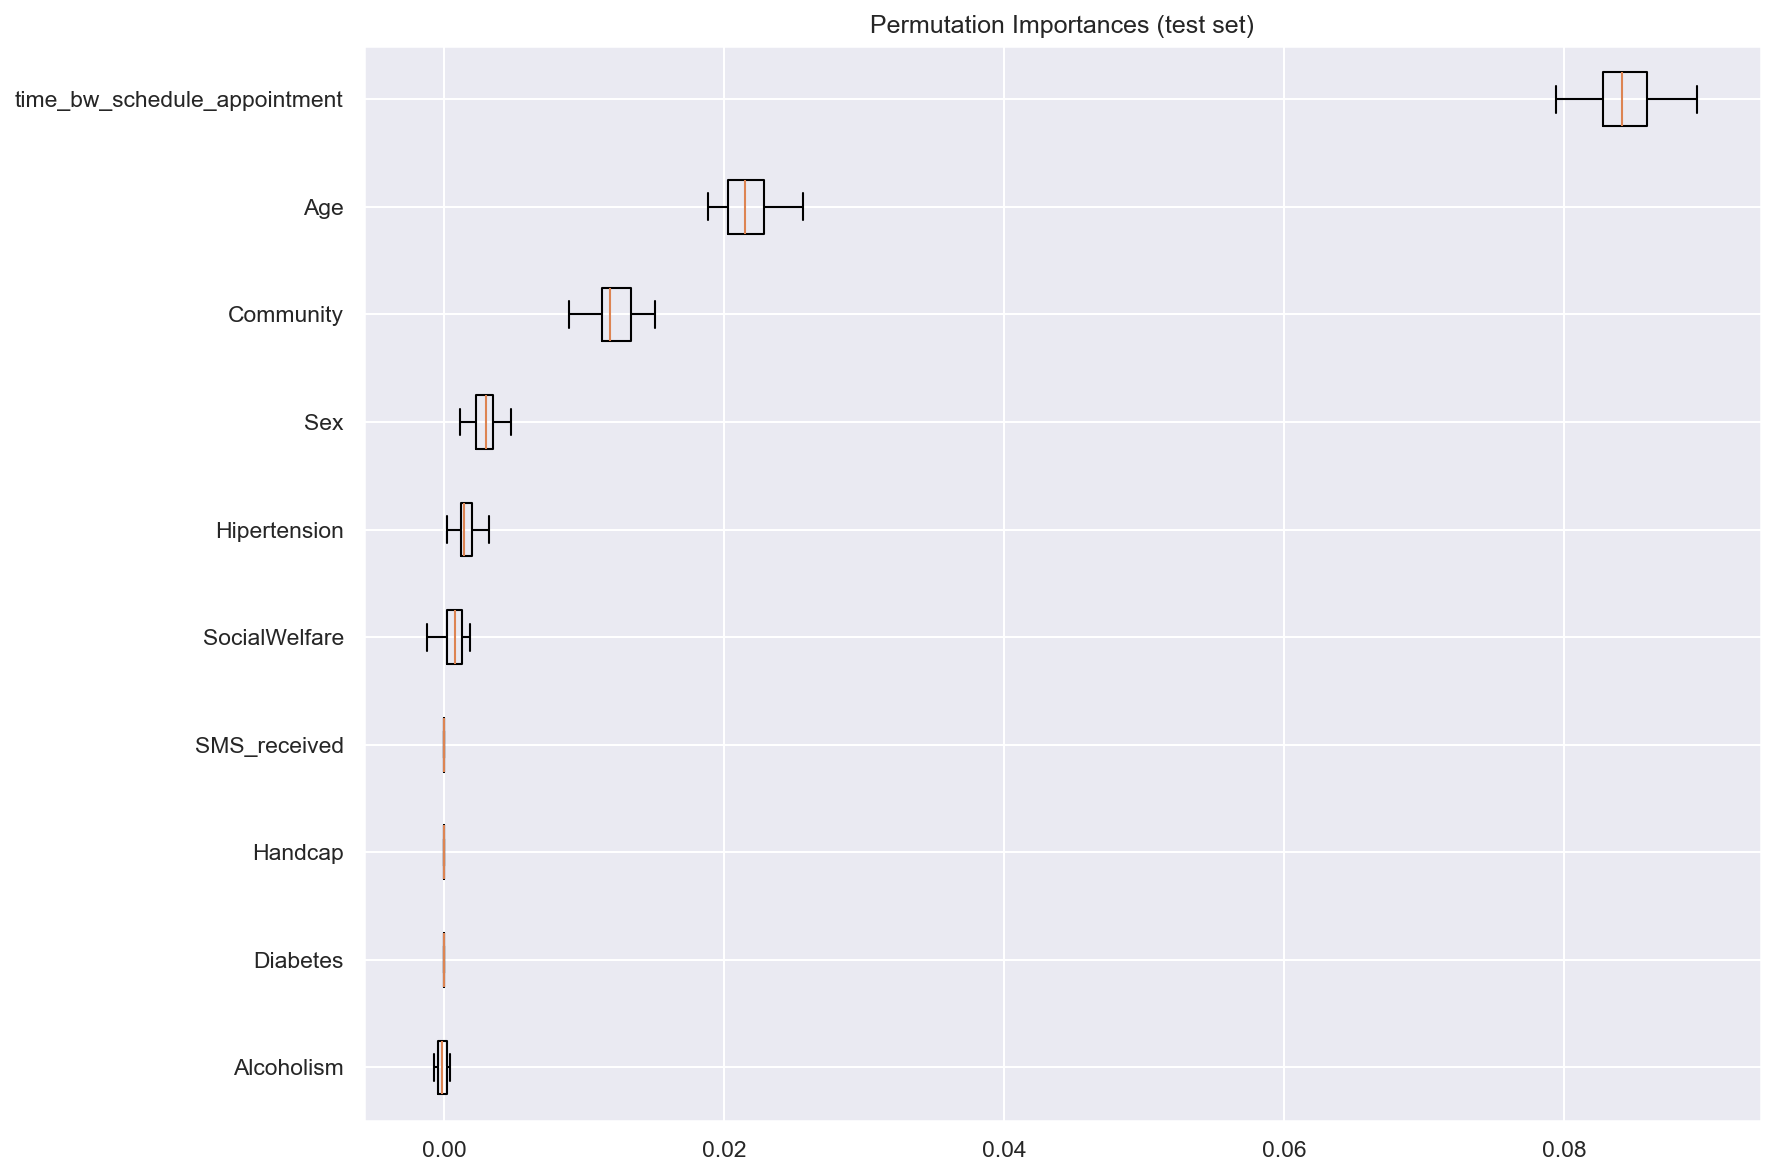

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Sorting the features by importance

sorted_idx = perm_result.importances_mean.argsort()

# Plotting to visualise more clearly

plt.figure(figsize=(12, 8))
plt.boxplot(perm_result.importances[sorted_idx].T, vert=False, labels=np.array(X_train.columns)[sorted_idx])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()

This resonates well with what we saw in feature selection efforts before. We use this to rethink our approach to considering columns such as SMS_received, handcap, diabetes, and alcoholism.

#### 9.2 Preprocessing test.cv

We apply the same basic transformations that we did to our training data set.

In [61]:
# Importing test.csv

df_test = pd.read_csv('/Users/muhammadraza/Documents/GitHub/BIPM/Data Science/Project/test.csv')

# Keeping original df_test intact:

df_test_t = df_test[:]

In [62]:
## Data Type Overview

df_test_t.dtypes

PatientId          float64
AppointmentID        int64
Sex                 object
ScheduledDate       object
AppointmentDate     object
Age                float64
Community           object
SocialWelfare       object
Hipertension        object
Diabetes            object
Alcoholism          object
Handcap             object
SMS_received        object
dtype: object

In [63]:
# Getting the dates in the right format

from datetime import datetime

df_test_t['AppointmentDate'] = df_test_t['AppointmentDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').date())
df_test_t['ScheduledDate'] = df_test_t['ScheduledDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').date())

In [64]:
# Replacing handcap numerical values to yes (same approach as in training data - see section 5 for more details)

import numpy as np

df_test_t.loc[df_test_t['Handcap'].isin(['2', '3', '4']), 'Handcap'] = 'yes'
df_test_t.info()
occ_test = df_test_t.groupby('Handcap').size().reset_index()
print(occ_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22106 entries, 0 to 22105
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PatientId        22106 non-null  float64
 1   AppointmentID    22106 non-null  int64  
 2   Sex              22106 non-null  object 
 3   ScheduledDate    22106 non-null  object 
 4   AppointmentDate  22106 non-null  object 
 5   Age              19955 non-null  float64
 6   Community        19461 non-null  object 
 7   SocialWelfare    19043 non-null  object 
 8   Hipertension     20089 non-null  object 
 9   Diabetes         22106 non-null  object 
 10  Alcoholism       18371 non-null  object 
 11  Handcap          22106 non-null  object 
 12  SMS_received     22106 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 2.2+ MB
  Handcap      0
0      no  21660
1     yes    446


In [65]:
# Since we still see some missing data, we extrapolating missing data as much as we can

missing_columns = ['Age', 'Community', 'SocialWelfare', 'Hipertension', 'Alcoholism']

for column in missing_columns:
    df_test_t[column] = df_test_t.groupby('PatientId')[column].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


/var/folders/1z/kkxxkq_90qldq3ngyx1pj0fr0000gn/T/ipykernel_42276/73403312.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_test_t[column] = df_test_t.groupby('PatientId')[column].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


In [66]:
# Adding New Feature: Time between ScheduledDate and AppointmentDate

df_test_t['time_bw_schedule_appointment'] = df_test_t['AppointmentDate'] - df_test_t['ScheduledDate']

## Convert to float (days)

df_test_t['time_bw_schedule_appointment'] = df_test_t['time_bw_schedule_appointment'] / pd.Timedelta(days=1)
df_test_t['time_bw_schedule_appointment'] = df_test_t['time_bw_schedule_appointment'].astype(float)

In [67]:
# Capitalising yes/no so they can be converted to binary column

df_test_t = df_test_t.applymap(lambda x: x.capitalize() if isinstance(x, str) else x)

/var/folders/1z/kkxxkq_90qldq3ngyx1pj0fr0000gn/T/ipykernel_42276/470778378.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_test_t = df_test_t.applymap(lambda x: x.capitalize() if isinstance(x, str) else x)


In [68]:
# Making the columns for train and test equal by removing the columns we removed from the training set.

X_df_test = df_test_t.drop(columns=['PatientId', 'AppointmentID', 'ScheduledDate', 'AppointmentDate'])

#### 9.2 Model Evaluation

Running the soft voting classifier on the test.csv file to see the performance on never seen before data.

In [69]:
# Using the ensemble learner pipe on the test dataset to make predictions

y_pred_test = pipe_svc.predict(X_df_test)

In [70]:
# Appending the results to the dataframe

df_test_t["No-show"] = y_pred_test

In [71]:
# Reverse mapping of No-show column to Yes/No as is the requirement of the submission

mapping = {0: 'No', 1: 'Yes'}

# Consolidating into one file

df_test_t["No-show"] = df_test_t["No-show"].replace(mapping)
Submission = df_test_t[["AppointmentID", "No-show"]]

# Ensuring the final result is as expected

Submission.head()

,AppointmentID,No-show
0,5620835,Yes
1,5741692,No
2,5673005,No
3,5579701,No
4,5652332,No


In [73]:
# Saving as csv in local directory

filepath = '/Users/muhammadraza/Documents/GitHub/BIPM/Data Science/Project/finalish.csv'
Submission.to_csv(filepath, index=False)

### 10. Business Recommendations

How our model would help the business?

- The hospital could use our predictions to make a decision on whether to remind the people to come to the appointment or allocate the slot to other patients.

Are both false positives and false negatives equally important?

- It would depend on what the hospital would want to optimise for and what their resource utilisation is like. If the current resources are being under utilized, then it might make sense to have some overbookings and look at the false positives as it expects some patients to not show up but they do.
- If the hospital resources are already over utilised, then we would want to look at the false negatives more as they tell us which ones actually show up from the ones not expecting to show up. For the hospital, this would mean that they want to reduce the number of people who show up but expected not to show up. Thus freeing their resources and accurately being able to allocate resources elsewhere.